In [38]:
import itertools
import pandas as pd
from collections import Counter
import numpy as np

table = pd.read_csv('finalTrain.csv')


accents = list(set(table.accent))
genders = list(set(table.gender))
classes = sorted([e for e in itertools.product(accents, genders)])
print (len(classes))
print (classes)

targets = [(row.accent, row.gender) for i, row in table.iterrows()]
target_counts = Counter(targets)

print (target_counts)

12
[('australia', 'female'), ('australia', 'male'), ('canada', 'female'), ('canada', 'male'), ('england', 'female'), ('england', 'male'), ('indian', 'female'), ('indian', 'male'), ('scotland', 'female'), ('scotland', 'male'), ('us', 'female'), ('us', 'male')]
Counter({('us', 'male'): 70445, ('england', 'male'): 33420, ('us', 'female'): 20493, ('indian', 'male'): 12507, ('australia', 'male'): 10453, ('canada', 'male'): 8226, ('indian', 'female'): 5752, ('canada', 'female'): 4833, ('england', 'female'): 4319, ('scotland', 'male'): 2590, ('australia', 'female'): 2167, ('scotland', 'female'): 1032})


In [39]:
weights = []
for c in classes:
    weights.append(1/target_counts[c])
weights = np.array(weights)
weights = weights / np.sum(weights)
print (weights)

[0.16370128 0.03393673 0.07339968 0.04312432 0.08213491 0.01061462
 0.06167258 0.02836337 0.34374096 0.13696551 0.01731033 0.00503571]


In [44]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
from os import path, listdir
from collections import Counter


class CommonVoiceDataset(torch.utils.data.Dataset):
  def __init__(self, csv_file, root_dir):
    self.csv_file = csv_file
    self.table = pd.read_csv(csv_file)
    self.root_dir = root_dir
    file_names = []
    mfccs = []
    for f in tqdm(sorted(listdir(root_dir))):
        mfcc = torch.Tensor(np.load(path.join(self.root_dir, f)))
        if len(mfcc) > 300:
            continue
        mfccs.append(mfcc)
        file_names.append(f)
        
    self.mfccs = mfccs
    self.file_names = file_names
    
  def __getitem__(self, i):
    mfcc = self.mfccs[i] # torch.Tensor(np.load(path.join(self.root_dir, self.file_names[i])))
    row = self.table[self.table.path == self.file_names[i].replace('.npy', '')]
    [sentence], [age], [accent], [gender] = row.sentence, row.age, row.accent, row.gender
    target = classes.index((accent, gender))
    return mfcc, torch.tensor(target)

  def __len__(self):
    return len(self.file_names)

def collate(batch):
  mfccs, targets = zip(*batch)
  mfccs = torch.nn.utils.rnn.pad_sequence(mfccs, batch_first=True, padding_value=0)
  targets = torch.stack(targets)
  return mfccs, targets 



import torch.nn.init as init

def weight_init(m):
  if isinstance(m, nn.Linear):
    init.xavier_normal_(m.weight.data)
    init.normal_(m.bias.data)
  elif isinstance(m, nn.LSTM):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)

valid_data = CommonVoiceDataset('finalVal.csv', 'validation')
train_data = CommonVoiceDataset('finalTrain.csv', 'train')

In [45]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from tqdm.auto import tqdm

class Net(nn.Module):
  def __init__(self, device):
    super(Net, self).__init__()
    self.hidden_size = 256
    self.num_layers = 2
    self.device = device
    self.lstm =  nn.LSTM(20, self.hidden_size, num_layers=self.num_layers, batch_first=True)
    self.fc1 = nn.Linear(self.num_layers * self.hidden_size, self.hidden_size*2)
    self.fc2 = nn.Linear(self.hidden_size*2, len(classes))

  def forward(self, x):
    h = torch.zeros(self.num_layers, len(x), self.hidden_size, dtype=torch.float).to(self.device)
    c = torch.zeros(self.num_layers, len(x), self.hidden_size, dtype=torch.float).to(self.device)
    
    h_lstm, _ = self.lstm(x, (h, c))
    # print (h_lstm.shape)
    avg_pool = torch.mean(h_lstm, 1)
    max_pool, _ = torch.max(h_lstm, 1)
    conc = torch.cat(( avg_pool, max_pool), 1)
    # print (conc.shape)
    dropout_p = 0.25
    conc = F.dropout(conc, p=dropout_p, training=self.training)
    encoded = F.dropout(F.relu(self.fc1(conc)), p=dropout_p, training=self.training)
    encoded = self.fc2(encoded).view(-1, len(classes))
    return encoded
    # return torch.softmax(encoded, 1)

import torch.nn.init as init

def weight_init(m):
  if isinstance(m, nn.Linear):
    init.xavier_normal_(m.weight.data)
    init.normal_(m.bias.data)
  elif isinstance(m, nn.LSTM):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)

device = torch.device('cuda')
net = Net(device).to(device)
net.apply(weight_init)



train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle=True, collate_fn=collate, num_workers=8, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = 64, shuffle=True, collate_fn=collate, num_workers=8, pin_memory=True)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99999)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weights).to(device))
train_losses = []
train_scores = []
valid_losses = []
valid_scores = []

for _ in range(8):
  net.train()
  for inputs, targets in tqdm(train_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    output = net(inputs)
    p = torch.argmax(torch.softmax(output, 1), 1)
    score = torch.mean((p == targets).float()).cpu().numpy()
    
    train_scores.append(score)
    loss = criterion(output, targets)
    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()
  print ('Train loss =', np.mean(train_losses[::-1][:len(train_loader)]))
  print ('Train score =', np.mean(train_scores[::-1][:len(train_loader)]))

  with torch.no_grad():
    net.eval()
    for inputs, targets in tqdm(valid_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      output = net(inputs)
      loss = criterion(output, targets)
      valid_losses.append(loss.item())
      p = torch.argmax(torch.softmax(output, 1), 1)
      score = torch.mean((p == targets).float())
      valid_scores.append(score.item())
    
    print ('Valid loss = ', np.mean(valid_losses[::-1][:len(valid_loader)]))
    print ('Valid score =', np.mean(valid_scores[::-1][:len(valid_loader)]), end='\n\n')


Train loss = 1.556762557675075
Train score = 0.28543246



Valid loss =  1.8994789431361776
Valid score = 0.336148502403184




Train loss = 1.0981187607961829
Train score = 0.44391978



Valid loss =  1.847481153415222
Valid score = 0.35013417585899953




Train loss = 0.9090432159779601
Train score = 0.51755095



Valid loss =  1.9892155514343788
Valid score = 0.41707063711395387




Train loss = 0.7609452595911389
Train score = 0.5796884



Valid loss =  2.01287353587778
Valid score = 0.42837549775446715




Train loss = 0.6584574804686308
Train score = 0.6259555



Valid loss =  2.172069321729635
Valid score = 0.4535023697504872




Train loss = 0.5721991895823866
Train score = 0.66303664



Valid loss =  2.4156927517370175
Valid score = 0.4107811418116877



KeyboardInterrupt: 

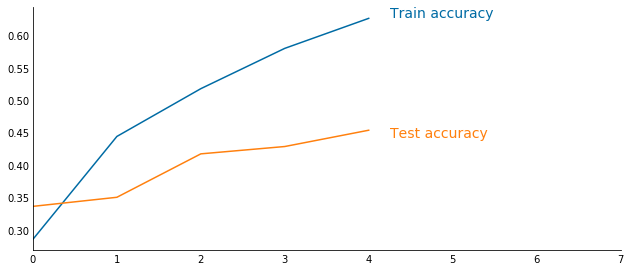

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
for i in range(len(tableau20blind)):
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)


tr = [np.mean(train_scores[start:start+len(train_loader)])  for start in range(0, len(train_scores), len(train_loader))]
plt.plot(tr[:-2], color=tableau20blind[0])

plt.xlim(0, len(tr))
te = [np.mean(valid_scores[start:start+len(valid_loader)]) for start in range(0, len(valid_scores), len(valid_loader))]
plt.plot(te[:-2], color=tableau20blind[1])

plt.text( len(tr)-2.75,tr[-1]-0.05,   'Train accuracy', color=tableau20blind[0], fontsize=14)
plt.text( len(te)-2.75,te[-1], 'Test accuracy', color=tableau20blind[1], fontsize=14)

# plt.ylim(30, 90)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.tight_layout(pad=5)
plt.gca().tick_params(axis='both', length=0)

In [47]:

ys = []
ps = []
with torch.no_grad():
    net.eval()
    for inputs, targets in tqdm(valid_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      ys += targets.cpu().numpy().tolist()
      output = net(inputs)
      loss = criterion(output, targets)
      valid_losses.append(loss.item())
      p = torch.argmax(torch.softmax(output, 1), 1)
      ps += p.cpu().numpy().tolist()
      score = torch.mean((p == targets).float())
      valid_scores.append(score.item())